# MODELE DE GENERATION DE DISFLUENCE

### Import des modules

In [1]:
# %env TF_FORCE_GPU_ALLOW_GROWTH=true
# %matplotlib widget
import tensorflow as tf
from tensorflow import keras
from tensorflow.data import TextLineDataset
from keras.layers import TextVectorization
from keras import initializers
from tensorflow.keras.utils import plot_model
import pickle
import re
import glob

### Préparation des données d'entrainement

In [2]:
dataset = TextLineDataset("../corpus/rhapstories.txt")
tv = TextVectorization(split="whitespace", ragged=True, output_mode='int')
tv.adapt(dataset)

2023-05-20 22:36:55.211439: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [3]:
def split_input_target(sequence):
    input_text = sequence
    target_text = tf.concat([sequence[1:], [1]], axis=0)
    return input_text, target_text

In [4]:
training_data = (
    dataset.shuffle(10000)
    .map(tv)
    .map(split_input_target)
    .padded_batch(32, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

### Chargement des vecteurs de mot pré-entrainés

In [5]:
embmtx = open("../embedding/embmtxvector.pickle", "rb")
embmtx = pickle.load(embmtx)
embmtx

array([[ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.0183, -0.0412, -0.0639, ...,  0.0287,  0.0386,  0.1699],
       ...,
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ]])

### Modèle

In [6]:
def build_model(tv: TextVectorization, lstm_size=64):
    inputs = keras.layers.Input(shape=(None,))
    embeddings = keras.layers.Embedding(len(embmtx),
                                        len(embmtx[0]),
                                        embeddings_initializer=initializers.Constant(embmtx),
                                        trainable=False,
                                        input_length=300)(inputs)
    rnn, _, _ = keras.layers.LSTM(lstm_size, return_state=True, return_sequences=True, name='rnn')(embeddings)
    classif = keras.layers.Dense(tv.vocabulary_size(), name='classif')(rnn)
    model = keras.Model(inputs=inputs, outputs=classif)
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer="adam", loss=loss)
    return model

In [7]:
model = build_model(tv,256)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         600000600 
                                                                 
 rnn (LSTM)                  [(None, None, 256),       570368    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
 classif (Dense)             (None, None, 5963)        1532491   
                                                                 
Total params: 602,103,459
Trainable params: 2,102,859
Non-trainable params: 600,000,600
_________________________________________________________________


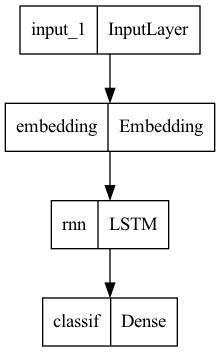

In [9]:
plot_model(model)

In [10]:
history = model.fit(training_data, epochs=10)

Epoch 1/10
201/201 [==============================] - 29s 134ms/step - loss: 2.7190
Epoch 2/10
201/201 [==============================] - 29s 145ms/step - loss: 1.9284
Epoch 3/10
201/201 [==============================] - 29s 147ms/step - loss: 1.8228
Epoch 4/10
201/201 [==============================] - 29s 145ms/step - loss: 1.7419
Epoch 5/10
201/201 [==============================] - 30s 148ms/step - loss: 1.6676
Epoch 6/10
201/201 [==============================] - 29s 145ms/step - loss: 1.5811
Epoch 7/10
201/201 [==============================] - 23s 116ms/step - loss: 1.5719
Epoch 8/10
201/201 [==============================] - 24s 118ms/step - loss: 1.5200
Epoch 9/10
201/201 [==============================] - 23s 116ms/step - loss: 1.4948
Epoch 10/10
201/201 [==============================] - 23s 115ms/step - loss: 1.4412


In [11]:
#model.save("./modele/modele_sans_tuner.h5")

In [12]:
modele = keras.models.load_model("./modele/modele_sans_tuner.h5")

### Générateur de phrases

In [13]:
class Generator():
    def __init__(self, model):
        """
        Constructeur
        :param model:
        """
        self.emb = model.get_layer('embedding')
        self.rnn = model.get_layer('rnn')
        self.classif = model.get_layer('classif')
        
    def _predict_next(self, last_word, state):
        """
        Permet de retourner l'indice
        du mot suivant last_word le
        plus probable.
        :param last_word:
        :param state:
        :return next_word, new_state:
        """
        e = self.emb(last_word)
        output, state_h, state_c = self.rnn(e, initial_state=state)
        new_state = [state_h, state_c]
        probs = self.classif(output)
        next_word = tf.math.argmax(probs, axis=-1)
        return next_word, new_state
    
    def predict_seq(self, sent):
        """
        Décode le mot suivant le plus probable
        et renvoie la phrase générée.
        :param sent:
        :return " ".join(result):
        """
        result = [sent]
        state = None
        word = tf.reshape(tv(sent.split()[-1]), [1, 1])
        stop = False
        while not stop:
            next_word, state = self._predict_next(word, state)
            decoded_word = tv.get_vocabulary()[tf.squeeze(next_word).numpy()]

            if decoded_word == "[UNK]" or len(result) > 15:
                stop = True
            else:
                result.append(decoded_word)
                word = next_word
        return " ".join(result)
            

In [14]:
gen = Generator(modele)

In [15]:
line = gen.predict_seq("alors")
print(line)

alors que je passais faire le ballon


In [16]:
line = gen.predict_seq("je")
print(line)

je fais pas mes courses


In [17]:
line = gen.predict_seq("je pense")
print(line)

je pense que je me souviens que que tu connais pas


In [18]:
line = gen.predict_seq("nous")
print(line)

nous réussirons


In [19]:
line = gen.predict_seq("mais")
print(line)

mais javoue


In [20]:
line = gen.predict_seq("il manque")
print(line)

il manque que même disons


In [21]:
line = gen.predict_seq("on mange")
print(line)

on mange je pense que que que je lavais pas compris


In [22]:
line = gen.predict_seq("elle")
print(line)

elle a pas abîmée


In [23]:
line = gen.predict_seq("il")
print(line)

il y a dabord un philosophe


### Générateur de statistiques

In [24]:
class GeneratorStat():
    def __init__(self, model):
        self.emb = model.get_layer('embedding')
        self.rnn = model.get_layer('rnn')
        self.classif = model.get_layer('classif')


    def _prediction_euh(self, last_word, state):
        """
        Récupère l'indice de "euh" et
        sa probabilité d'apparaitre après
        last_word.
        :param last_word:
        :param state:
        :return new_state, probability_euh:
        """
        e = self.emb(last_word)
        output, state_h, state_c = self.rnn(e, initial_state=state)
        new_state = [state_h, state_c]
        probs = self.classif(output)
        vocab = tv.get_vocabulary()  # Obtention du vocabulaire
        euh_index = vocab.index("euh")  # Recherche de l'index de "euh" dans le vocabulaire
        probability_euh = tf.squeeze(probs).numpy()[euh_index]  # Récupération de la probabilité de "euh"

        return new_state, probability_euh

    def predict_euh(self, sent):
        """
        Retourne la probabilité moeyenne de "euh"
        pour une phrase donnée.
        :param sent:
        :return total_proba/len(phrase):
        """
        phrase = sent.split()
        state = None
        total_proba = 0

        for mot in phrase :
            try:
                word = tf.reshape(tv(mot),[1,1])
                state, proba = self._prediction_euh(word, state)
                total_proba+=proba
            except:
                continue
        return total_proba/len(phrase)

    def statistics(self,liste):
        """
        Retourne la probabilité moyenne
        globale de "euh" pour une liste de phrases
        données.
        :param liste:
        :return totalmoyenne/len(liste):
        """
        totalmoyenne = 0
        for phrase in liste:
                moyenne = self.predict_euh(phrase)
                totalmoyenne+=moyenne

        return totalmoyenne/len(liste)

    def predict_euh_pos(self, sent):
        """
        Retourne un dictionnaire des probabilités "euh"
        par partie du discours pour une phrase donnée.
        :param sent: sous forme de liste de tuples (mot, pos)
        :return total_proba/len(phrase):
        """
        state = None
        dico = {}
        for mot, pos in sent:
            if pos != "PUNCT":
                try:
                    word = tf.reshape(tv(mot),[1,1])
                    state, proba = self._prediction_euh(word, state)
                    try:
                        dico[pos].append(proba)
                    except:
                        dico[pos] = [proba]
                except:
                    continue
        return dico

    def statistics_pos(self, liste):
        """
        Retourne un dictionnaire avec la probabilité
        moeyenne de "euh" en fonction de la partie
        du discours pour une liste de phrases donnée.
        :param sent:
        :return total_proba/len(phrase):
        """
        total_dico = {}
        total_stat = {}
        for phrase in liste:
            dico = self.predict_euh_pos(phrase)
            for k, v in dico.items():
                try:
                    total_dico[k].extend(v)
                except:
                    total_dico[k] = v

        for k, v in total_dico.items():
            total_stat[k] = sum(v)/len(v)

        return total_stat

In [25]:
genstat = GeneratorStat(modele)

### Préparation des données de test pour la probabilité globale de "euh"

In [26]:
text_files = glob.glob("../corpus/*test.conllu")
phrase_sans_disfluence = []

for file in text_files:
    with open(f"{file}") as file:
        file = file.read().strip().split("\n\n")
        for phrase in file:
            phrase = phrase.strip().split("\n")
            newphrase = ""
            for i, line in enumerate(phrase):
                line = line.split("\t")
                if line[0].isdigit():
                    if line[7] != "discourse" and line[7] != "reparandum" and line[3] != "INTJ":
                            newphrase += line[1] + " "

            newphrase = re.sub("n' -ce pas", "", newphrase)
            newphrase = re.sub("^(de le|et)", "", newphrase)
            newphrase = re.sub("de le", "du", newphrase)
            newphrase = re.sub("(, )+", "\\1", newphrase)
            newphrase = re.sub("^[, ]", "", newphrase)
            newphrase = re.sub(" ([,.])", "\\1", newphrase)
            newphrase = re.sub("(') ", "\\1", newphrase)

            newphrase = newphrase.split()
            for i in range(1, round(len(newphrase) / 2)):
                wgroup = []

                # formation des groupes de mots en fonction i
                for word in range(0, len(newphrase), i):
                    ngram = " ".join(newphrase[word:word + i])
                    wgroup.append(ngram)

                # on vérifie à chaque tour s'il n'y pas de répétition de mot ou groupe de mot
                newphrase = [word for i, word in enumerate(wgroup) if i == len(wgroup) - 1 or word != wgroup[i + 1]]

                # on récupère la dernière modification et on reforme une liste d'unigramme
                newphrase = " ".join(newphrase).split()

            phrase_sans_disfluence.append(" ".join(newphrase).strip())

In [27]:
probabilite_globale = genstat.statistics(phrase_sans_disfluence)
print(probabilite_globale)

9.008270996923525


### Préparation des données de test pour la probabilité de "euh" par partie du discours

In [28]:
text_files = glob.glob("../corpus/*test.conllu")
phrase_sans_disfluence_pos = []

for file in text_files:
    with open(f"{file}") as file:
        file = file.read().strip().split("\n\n")
        for phrase in file:
            phrase = phrase.strip().split("\n")
            newphrase = []
            for i, line in enumerate(phrase):
                line = line.split("\t")
                if line[0].isdigit():
                    if line[7] != "discourse" and line[7] != "reparandum" and line[3] != "INTJ":
                            newphrase.append((line[1], line[3]))

            if newphrase[0][0] == "et":
                del newphrase[0]
            if newphrase[0][0] == "de" and newphrase[1][0] == "le":
                del newphrase[1]
                del newphrase[0]

            for i, tpl in enumerate(newphrase):
                try:
                    if newphrase[i][0] == "de" and newphrase[i+1][0] == "le":
                        newphrase[i] = ('du', 'DET')
                        del newphrase[i+1]
                except:
                    continue
                try:
                    if newphrase[i][0] == newphrase[i+1][0]:
                        del newphrase[i+1]
                except:
                    continue

            phrase_sans_disfluence_pos.append(newphrase)


In [29]:
pos_stat_dico = genstat.statistics_pos(phrase_sans_disfluence_pos)
print(pos_stat_dico)

{'PRON': 10.507576696559797, 'VERB': 8.989624036334764, 'DET': 9.939329448840027, 'ADJ': 8.002259318368036, 'NOUN': 8.337624037763112, 'ADP': 9.166374223459586, 'PROPN': 7.60009367220249, 'ADV': 9.289528548343567, 'SCONJ': 10.61972082973866, 'CCONJ': 9.802812480491045, 'AUX': 9.857281604620928, 'NUM': 8.293101313379076, 'X': 10.415473143259684}
